# Build a RA2CE model for FloodAdapt anywhere on the globe

In this notebook we demonstrate how to setup a RA2CE model for the FloodAdapt backend at any given location. As an example we will use the Humber delta in the UK.

## **Step 0:** Import dependencies

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr
from rasterio.features import rasterize
from xrspatial import zonal_stats
import osmnx as ox
from shutil import copy

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

proj = ccrs.PlateCarree() # plot projection

from hydromt.data_catalog import DataCatalog

from DT_flood.utils.ra2ce_utils import setup_base_folder, setup_ra2ce

Setup folders

In [2]:
model_name = 'Humber'
model_path = Path('/home/wotromp/InterTwin/FloodAdapt_database') / model_name

ra2ce_root = model_path / Path('static/templates/ra2ce')

region_fn = model_path / 'HumberDelta_large.geojson'
region = gpd.read_file(region_fn)

In [ ]:
setup_base_folder(ra2ce_root)
copy(region_fn, ra2ce_root/"static"/"network"/"map.geojson")

Create origin points

In [5]:
dc_fn = Path("/home/wotromp/InterTwin/Data/Humber/data_catalog.yml")
dc = DataCatalog(data_libs=[dc_fn])

In [6]:
worldpop = dc.get_rasterdataset("worldpop", geom=region)
gadm = dc.get_geodataframe("gadm_level4", geom=region)

In [7]:
shapes = list(enumerate(gadm['geometry'].values))
shapes = [(t[1],t[0]+1) for t in shapes]

In [8]:
rasterized = rasterize(
    shapes=shapes,
    out_shape=worldpop.shape,
    transform=worldpop.raster.transform,
    all_touched=True
)
# zonal_stats needs xarrays as input
rasterized = xr.DataArray(rasterized,
                          coords={
                              "y": worldpop.y,
                              "x": worldpop.x,
                          })

In [9]:
# Calculate the zonal statistics
zonal_out = zonal_stats(rasterized,worldpop.load(),
                        stats_funcs=['sum'],
                        nodata_values=np.nan)

# The zero label is for pixels not in a geometry so we discard them
zonal_out = zonal_out.drop(0)

In [10]:
origins = gpd.GeoDataFrame(data=zonal_out, geometry=gadm.geometry.centroid).dropna()
origins = origins.rename(columns={
    "sum": "POPULATION",
    "zone": "OBJECT ID"
})
origins = origins.clip(region)
origins['category'] = 'origin'

In [ ]:
origins.to_file(ra2ce_root/"static"/"network"/"origins.gpkg", driver="GPKG")

In [ ]:
fig = plt.figure(figsize=(10,8))
ax= plt.subplot(projection=proj)
ax.add_image(cimgt.OSM(),10)

origins.plot(ax=ax, column="POPULATION", zorder=10, legend=True,
             legend_kwds={
                 "label": "Population per region",
                 "shrink": 0.75,
                 "pad": 0.02,
                 "orientation": "horizontal"
             })
xlim = ax.get_xlim()
ylim = ax.get_ylim()
gadm.boundary.plot(ax=ax, color='k')

ax.set_title("RA2CE Origin points")
ax.set_xlim(xlim)
ax.set_ylim(ylim)

Create Destination Points

In [11]:
feats = ox.features_from_polygon(region.geometry[0],tags={"amenity":["hospital"]})

In [12]:
dest= feats.reset_index()[["osmid","amenity","geometry"]]
dest = dest.rename(columns={"amenity": "category"})
dest['geometry'] = dest['geometry'].centroid

/tmp/ipykernel_23828/3421620274.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dest['geometry'] = dest['geometry'].centroid


In [ ]:
dest.to_file(ra2ce_root/"static"/"network"/"destinations.gpkg", driver="GPKG")

In [ ]:
fig = plt.figure(figsize=(10,8))
ax= plt.subplot(projection=proj)
ax.add_image(cimgt.OSM(),10)

origins.plot(ax=ax, column="POPULATION")
# dest.plot(ax=ax, marker='o', color="w", markersize=50)
dest.plot(ax=ax, marker='P', color="r", markersize=150, edgecolor='w', linewidth=2)

Setup RA2CE network

In [ ]:
setup_ra2ce(model_path)

Plot RA2CE network

In [3]:
network_fn = ra2ce_root/"static"/"output_graph"/"base_network.gpkg"
network = gpd.read_file(network_fn)

In [15]:
hazard_fn = model_path / "output" / "Scenarios" / "Empty_Event_current_no_measures" / "Flooding" / "FloodMap_Empty_Event_current_no_measures.tif"

True

In [25]:
hazard = xr.open_dataarray(hazard_fn)

In [29]:
network_repr = network.to_crs(hazard.raster.crs)

(5922804.1810254175, 5969743.23382125)

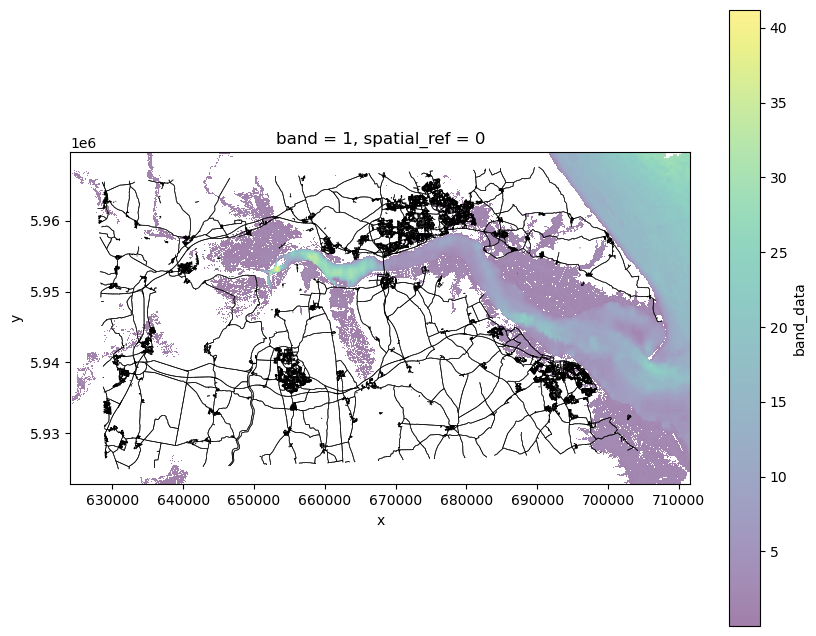

In [32]:
fig = plt.figure(figsize=(10,8))
ax= plt.subplot()
# ax.add_image(cimgt.OSM(),10)

network_repr.plot(ax=ax, color='k', linewidth=.5)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
hazard.plot(ax=ax, zorder=1, alpha=0.5)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

In [20]:
hazard = hazard.raster.reproject(4326)

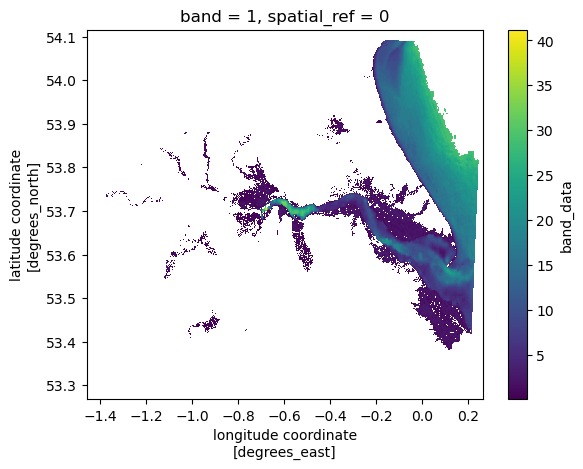

In [22]:
hazard.plot()

(53.43850191, 53.84076289)

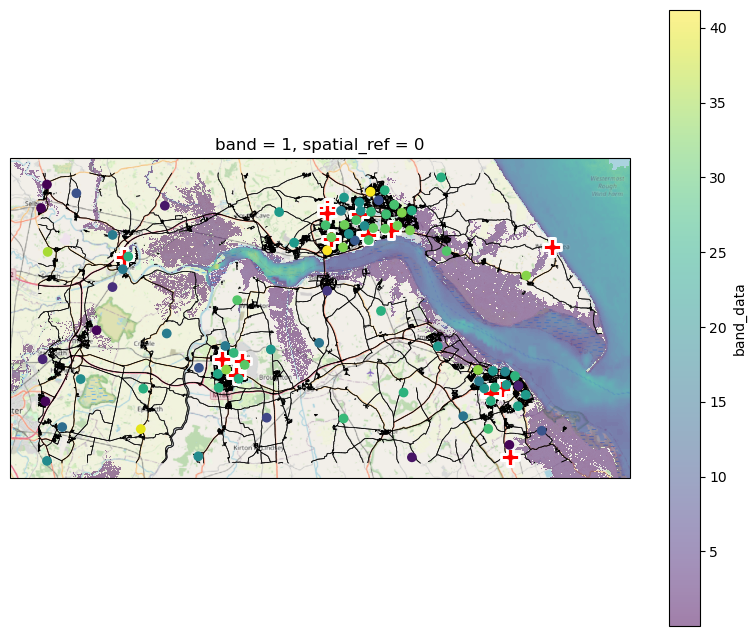

In [24]:
fig = plt.figure(figsize=(10,8))
ax= plt.subplot(projection=proj)
ax.add_image(cimgt.OSM(),10)

network.plot(ax=ax, color='k', linewidth=.5)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
origins.plot(ax=ax, column="POPULATION", zorder=10)
dest.plot(ax=ax, marker='P', color="r", markersize=150, edgecolor='w', linewidth=2,zorder=9)
hazard.plot(ax=ax, zorder=1, alpha=0.5)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

In [ ]:
network.explore(column='highway')